In [1]:
import requests
import pandas as pd
import numpy as np

from typing import List, Any, Dict
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

#### Data import

In [2]:
api_link = "https://api.elhub.no/energy-data/v0/consumption-groups"

response = requests.get(api_link)
response.raise_for_status()

data = response.json()

consumption_groups = [i["id"] for i in data["data"]]

print(consumption_groups)

['household', 'cabin', 'primary', 'secondary', 'tertiary', 'industry', 'private', 'business', '*']


groups:
* Household:
    * Normal Homes
* Cabin
    * Cabins and secondary homes
* Primary Industry
    * Resource extraction
* Secondary Industry
    * Production
* Tertiary Industry
    * Services

Rest is combination groups (household + cabin etc)

In [3]:
from datetime import timedelta


def get_consumption_data(area: str, 
                         start_time: datetime = datetime(year=2023, month=1, day=1), 
                         end_time: datetime = datetime(year=2023, month=3, day=1)
                         ) -> List[Dict[str, Any]]:
    api_link = "https://api.elhub.no/energy-data/v0/price-areas"

    result = []
    while start_time < end_time:
        # API only allows for time intervals of max 1 month.
        temp_end = min(start_time + timedelta(weeks=4), end_time)

        params = {
            "dataset": "CONSUMPTION_PER_GROUP_MBA_HOUR",
            "startDate": f"{start_time.isoformat()}+02:00",
            "endDate": f"{temp_end.isoformat()}+02:00",
        }

        response = requests.get(f"{api_link}/{area}", params=params)
        response.raise_for_status()

        result.extend(response.json()["data"][0]["attributes"]["consumptionPerGroupMbaHour"])
        start_time = temp_end

    return result

data = get_consumption_data("NO5", start_time=datetime(year=2021, month=1, day=1), end_time=datetime(year=2025, month=1, day=1))

In [13]:
consumption_df = pd.DataFrame(data)
consumption_df["startTime"] = pd.to_datetime(consumption_df["startTime"], utc=True).dt.tz_convert('Europe/Oslo')

# sort usage by start time and consumption group
consumption_by_group = consumption_df.pivot_table(
    index="startTime",
    columns="consumptionGroup",
    values="quantityKwh"
    ).sort_index()

hour_consumption_by_group = consumption_by_group.groupby(consumption_by_group.index.hour).mean()
month_consumption_by_group = consumption_by_group.groupby(consumption_by_group.index.month).mean()
weekday_consumption_by_group = consumption_by_group.groupby(consumption_by_group.index.weekday).mean()
year_consumption_by_group = consumption_by_group.groupby(consumption_by_group.index.year).mean()

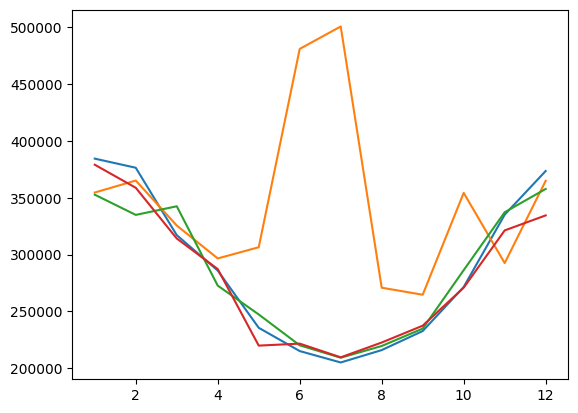

In [ ]:
yearly_consumption_by_group = {}
periods = ["month", "day", "hour", "weekday"]

for group in consumption_by_group.columns:
    yearly_consumption_by_group[group] = {}

    group_data = consumption_by_group.copy()
    group_data["year"] = consumption_by_group.index.year
    group_data["month"] = consumption_by_group.index.month
    group_data["day"] = consumption_by_group.index.day
    group_data["weekday"] = consumption_by_group.index.weekday
    group_data["hour"] = consumption_by_group.index.hour

    group_data = group_data.pivot_table(
        index=periods,
        columns="year",
        values=group
    )
    for period in periods:
        yearly_consumption_by_group[group][period] = group_data.groupby(period).mean()

plt.plot(yearly_consumption_by_group["tertiary"]["month"])

In [10]:
consumption_by_group.columns

Index(['cabin', 'household', 'primary', 'secondary', 'tertiary'], dtype='str', name='consumptionGroup')

C:\Users\tobso\AppData\Local\Temp\ipykernel_35728\3766210172.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


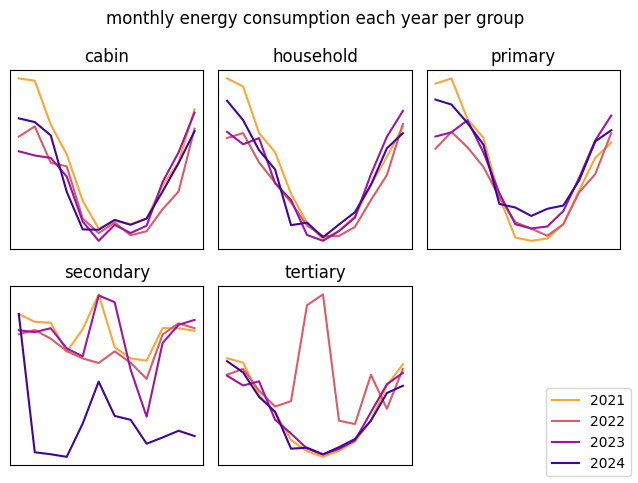

In [ ]:
year_data = {
    "hour" : [],
    "weekday" : [],
    "month": []
}
for year in range(2021, 2025):
    year_stats = consumption_by_group[consumption_by_group.index.year == year]

    year_stats_hour = year_stats.groupby(year_stats.index.hour).mean()
    year_stats_month= year_stats.groupby(year_stats.index.month).mean()
    year_stats_weekday = year_stats.groupby(year_stats.index.weekday).mean()

    year_data["hour"].append(year_stats_hour)
    year_data["weekday"].append(year_stats_weekday)
    year_data["month"].append(year_stats_month)

fig, ax = plt.subplots(nrows=2, ncols=3)
cmap = plt.cm.plasma(np.linspace(0.8, 0.1, len(year_data["month"])))

for i, name in enumerate(month_consumption_by_group.columns):
    for j, data in enumerate(year_data["month"]):
        ax[i//3, i%3].plot(data[name], color=cmap[j])
        ax[i//3, i%3].set_xticks([])
        ax[i//3, i%3].set_yticks([])
        ax[i//3, i%3].set_title(name)

fig.delaxes(ax[1, 2])
fig.legend(["2021", "2022", "2023", "2024"], loc="lower right")
fig.suptitle("monthly energy consumption each year per group")
fig.tight_layout()
fig.show()

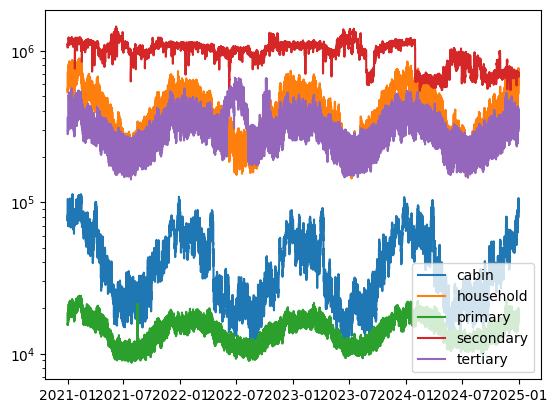

In [ ]:
plt.plot(consumption_by_group[1:-1]) # 1:-1 is here because of timezone schenanigans
plt.legend(month_consumption_by_group.columns, loc="lower right")
plt.yscale('log') 
plt.show()

#### 1. Utvikling i strømforbruk
Hvordan har strømforbruket i **NO5** utviklet seg de siste årene blant de forskjellige forbrukergruppene?  
Har forbruksmønsteret endret seg siden 2021?

In [ ]:
consumption_by_group

consumptionGroup,cabin,household,primary,secondary,tertiary
startTime,,,,,
2021-01-01 01:00:00+02:00,83301.550,565464.94,15941.561,1094799.60,281465.94
2021-01-01 02:00:00+02:00,81239.060,561738.70,15635.410,1099480.80,281856.97
2021-01-01 03:00:00+02:00,78309.660,552567.06,15568.727,1054455.90,282018.25
2021-01-01 04:00:00+02:00,75951.555,539974.00,15459.587,1049728.60,283190.28
2021-01-01 05:00:00+02:00,75057.690,530040.00,15537.723,1099942.90,284519.10
...,...,...,...,...,...
2024-12-31 20:00:00+02:00,100078.420,682969.70,18907.658,702756.00,346026.90
2024-12-31 21:00:00+02:00,94232.630,646786.10,18470.096,697851.06,335686.75
2024-12-31 22:00:00+02:00,90022.664,620832.06,17782.635,698963.10,325012.30
